# Risk Management_GWP 3_Group 6429

**Mahesha Bharatha Herath | Yu Li | Manju Ramasubbiah**

#All Installs

In [ ]:
!pip install pgmpy
!pip install --upgrade hmms
!pip install fredapi
!pip install --upgrade --user hmmlearn
!pip install --upgrade --user setuptools_scm

# Data Sourcing and Cleaning

The following code is adapted from "Minimal working example" Alvi, Danish A. Application of Probabilistic Graphical Models in Forecasting Crude Oil Price. 2018. University College London, Dissertation, pp.45.

The code has been tweaked a bit to be able to run in the current python libaries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmms
import requests


import pandas_datareader.data as web

In [ ]:
# common functions

import datetime # Using the datetime library

def convert_to_datetime(input):
  return datetime.datetime.strptime(input[:9], "%Y %m ").date();

"""
  Clean a dataframe used for Bayseian network
"""
def clean_EIA(data):
  data.replace('-', np.nan, regex=True, inplace=True);
  data.bfill(inplace=True);

  #data.index = data.index.map(convert_to_datetime);
  data.index = pd.to_datetime(data.index);
  #return data

"""
  Create dataframe from EIA API response
"""
def df_from_response (data, dataset):
    # Sorting data by periods in case they are out of order
    timePeriod = [item['period'] for item in data['response']['data']]
    valTotal = [float(item['value']) for item in data['response']['data']]
    sorted_data = sorted(zip(timePeriod, valTotal))
    periods, values = zip(*sorted_data)

    df = pd.DataFrame({
        'period': periods,
        dataset: values
    })

    df['period'] = pd.to_datetime(df['period'])
    df.set_index('period', inplace=True)

    return df

In this step we use source data required to build a discrete HMM. Data is sourced from

*   EIA
*   FRED



In [ ]:
# Dataset series ID from the EIA

# Annual datasets
datasets_eia_A = ['RGDPQ_NONOECD',  # Non-OECD Real Gross Domestic Product
                  'RGDPQ_OECD'      # OECD Real Gross Domestic Product
                ]

#montly datasets
datasets_eia  = ['PAPR_NONOPEC',    # Total non-OPEC Liquids Petroleum Production
                 'PAPR_OPEC',       # Total OPEC Liquids Petroleum Production
                 'PATC_OECD',       # OECD Total Capital Formation
                 'PATC_NON_OECD',   # Non-OECD Total Capital Formation
                 'COPRPUS',         # OECD Total Capital Formation
                 'CORIPUS',         # Non-OECD Total Capital Formation
                 'PASC_OECD_T3',    # OECD Total Capital Formation
                 #'PASC_NONOECD_T3', # Non-OECD Total Capital Formation
                 #'COPC_OPEC',       # OPEC Total Capital Formation
                 #'COPC_OPEC',       # Non-OPEC Total Capital Formation
                 'T3_STCHANGE_OOECD',
                 'T3_STCHANGE_NOECD'
                 ]

# ['PAPR_NONOPEC', 'PAPR_OPEC',  'PATC_OECD','PATC_NON_OECD', 'COPRPUS', 'CORIPUS',  'PASC_OECD_T3', 'COPS_OPEC', 'COPC_OPEC', 'T3_STCHANGE_OOECD', 'T3_STCHANGE_NOECD']

In [ ]:
data_merge = []; # List of dataframes to be concatenated


# annual data
for dataset in datasets_eia_A:
    url = f'https://api.eia.gov/v2/steo/data/?frequency=annual&data[0]=value&facets[seriesId][]={dataset}&start=2003-01&end=2024-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV'
    print (url)

    df = df_from_response (requests.get(url).json(), dataset)
    #create monthly
    df = df.resample('M').bfill()
    clean_EIA (df)
    df.index = [pd.Timestamp(x.year, x.month, 1) for x in df.index.tolist()]
    data_merge.append (df)


# monthly data
for dataset in datasets_eia:
    url = f'https://api.eia.gov/v2/steo/data/?frequency=monthly&data[0]=value&facets[seriesId][]={dataset}&start=2003-01&end=2023-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV'
    print (url)
    df = df_from_response (requests.get(url).json(), dataset)
    clean_EIA (df)
    data_merge.append (df)


https://api.eia.gov/v2/steo/data/?frequency=annual&data[0]=value&facets[seriesId][]=RGDPQ_NONOECD&start=2003-01&end=2024-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV
https://api.eia.gov/v2/steo/data/?frequency=annual&data[0]=value&facets[seriesId][]=RGDPQ_OECD&start=2003-01&end=2024-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV
https://api.eia.gov/v2/steo/data/?frequency=monthly&data[0]=value&facets[seriesId][]=PAPR_NONOPEC&start=2003-01&end=2023-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV
https://api.eia.gov/v2/steo/data/?frequency=monthly&data[0]=value&facets[seriesId][]=PAPR_OPEC&start=2003-01&end=2023-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV
https://api.eia.gov/v2/steo/data/?frequenc

In [ ]:
# Data from FRED
datasets_fred = [
                        'CPIENGSL',
                        'CAPG211S',
                        'CAPUTLG211S',
                        'IPG211S',
                        'IPG211111CN',
                        'INDPRO',
                        'IPN213111N',
                        'PCU211211',

                ];

In [ ]:
# Set the date range for the data
start_date = '2003-01-01'
end_date = '2024-01-01'

for series_id in datasets_fred:
  df = web.DataReader(series_id, 'fred', start_date, end_date)
  data_merge.append(df);

In [ ]:
#Oil Prices from FRED

current = web.DataReader('WTISPLC', 'fred', start_date, end_date)
current ['forecast'] = current['WTISPLC'].shift(-1)
data_merge.append(current);


In [ ]:
data = pd.concat(data_merge, axis=1, join='outer')
data = data.fillna(method='ffill')

<ipython-input-76-fb81169e0bdd>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Create a combined dataset

In [ ]:
data = pd.concat(data_merge, axis=1, join='inner');

In [ ]:
# Create train, validation and test datasets

train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

In [ ]:
test_data

,RGDPQ_NONOECD,RGDPQ_OECD,PAPR_NONOPEC,PAPR_OPEC,PATC_OECD,PATC_NON_OECD,COPRPUS,CORIPUS,PASC_OECD_T3,COPC_OPEC,...,CPIENGSL,CAPG211S,CAPUTLG211S,IPG211S,IPG211111CN,INDPRO,IPN213111N,PCU211211,WTISPLC,forecast
2021-12-01,129.402023,113.999711,66.165741,32.088172,47.444092,53.705636,11.678139,15.756903,2640.155430,30.27000,...,267.042,131.0858,97.4004,127.6781,165.4243,101.1948,99.8211,229.298,71.71,83.22
2022-01-01,135.109056,115.906142,66.031097,32.233705,44.342738,52.989597,11.479767,15.467677,2645.332850,30.07000,...,267.529,131.4245,96.2429,126.4868,165.4243,101.2146,102.0942,239.179,83.22,91.64
2022-02-01,135.109056,115.906142,66.150714,32.841824,46.489435,54.057842,11.257889,15.397286,2617.876228,30.30000,...,275.479,131.8421,94.2154,124.2155,165.4243,101.8458,104.0953,284.556,91.64,108.50
2022-03-01,135.109056,115.906142,67.152430,32.485829,46.045755,53.307132,11.806029,15.846807,2604.248099,30.13000,...,301.162,132.3334,97.4009,128.8939,165.4243,102.6732,105.4073,275.256,108.50,101.78
2022-04-01,135.109056,115.906142,66.048125,32.730196,44.396742,53.641050,11.769842,15.648300,2654.957189,30.00000,...,298.070,132.8919,97.3551,129.3770,165.4243,102.9024,107.8925,295.846,101.78,109.55
2022-05-01,135.109056,115.906142,66.421198,32.280727,44.808109,54.475063,11.734402,16.238774,2666.485406,29.62000,...,309.968,133.5158,97.1489,129.7091,165.4243,102.9659,112.0101,339.024,109.55,114.84
2022-06-01,135.109056,115.906142,66.662140,32.455774,45.988883,55.084642,11.800309,16.571000,2656.570603,29.55000,...,331.738,134.2009,97.2947,130.5703,165.4243,102.8224,113.5282,374.936,114.84,101.62
2022-07-01,135.109056,115.906142,67.572823,32.767791,45.576243,54.711614,11.834305,16.358000,2710.068088,29.36000,...,315.749,134.9341,97.7918,131.9544,165.4243,103.0505,115.3336,315.785,101.62,93.67
2022-08-01,135.109056,115.906142,67.208418,33.758840,46.435684,54.453270,11.985232,16.427677,2709.851580,29.89000,...,299.730,135.7080,97.5474,132.3796,165.4243,103.1703,116.6146,350.329,93.67,84.26
2022-09-01,135.109056,115.906142,67.488166,33.873923,46.018945,55.112655,12.325190,16.141200,2735.679108,29.97000,...,293.505,136.5130,98.8092,134.8874,165.4243,103.5326,115.8895,322.595,84.26,87.55


https://api.eia.gov/v2/petroleum/move/impcus/data/?frequency=monthly&data[0]=value&facets[series][]=MCRIMXX2&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=xakJYziEnN9QMMYXQmYpXRd7nJXANUH94J1gG1TV

###Show and plot the oil price data which we need to forecast


Source  'WTISPL' (Spot Crude Oil Price: West Texas Intermediate) from FRED  and try to identify regimes in the time series.

In [ ]:

# Set the date range for the data
start_date = '1995-01-01'
end_date = '2024-01-01'

# SOurce WTI data from FRED
oil_prices = web.DataReader('WTISPLC', 'fred', start_date, end_date)
oil_prices.head()

,WTISPLC
DATE,
1995-01-01,17.99
1995-02-01,18.53
1995-03-01,18.55
1995-04-01,19.87
1995-05-01,19.74


Next transform data into discrete emissions - achieve  this by calculating the first-order difference and assigning 1 to a positive change and 0 to a negative change  

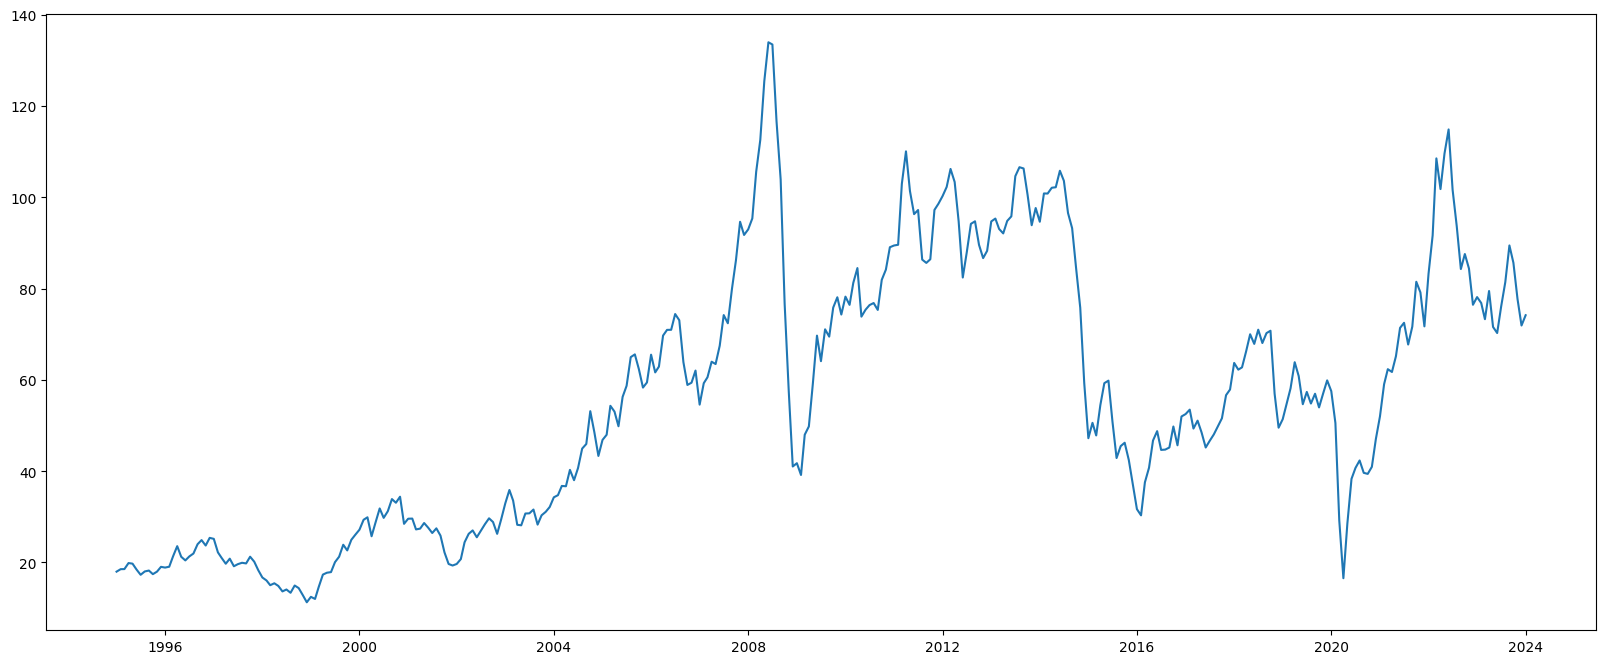

In [ ]:
# The first value is NaN as there is not a previous month to compare with
oil_prices_diff = oil_prices.diff()[1:]

#resize plot
plt.rcParams['figure.figsize'] = [20,8]

# Plot the time series
plt.plot(oil_prices)

# Replacing the change with 1 if positive, else 0
e_seq = np.array(oil_prices_diff['WTISPLC'].apply(lambda x: 1 if x > 0 else 0).values);

#Creates Discrete-time HMM

Uses 3 hidden states and 2 possible emissions (0 and 1).

#### HMM Parameter Learning -

Given the data what HMM parameters - what HMM parameters best represent the data - we use the Python hmms library to create and train the HMM.

We dont know the parameters of the model but can learn if we provide sufficient data using an  EM algorithm - in our case Baum-Welch algorithm

We perform the following steps across all datasets beginning with Oil Price data:

1. First creates a random Discrete-time HMM with 3 hidden states and 2 possible emissions (0 and 1).

2. Set up data for the hmms library - i.e. the data input to train the model   

3. Apply Baum-Welch algorithm for 100 iterations to learn HMM parameters - in our case we use three states and two observations

In [ ]:
#creates a random Discrete-time HMM with 3 hidden states and 2 possible emissions (0 and 1).
dhmm_r = hmms.DtHMM.random(3 , 2);

e_seq = np.array_split(e_seq, 32)

dhmm_r.baum_welch(e_seq, 100); # 100 iterations

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

After the training we have learn the HMM model parameters, we print it here

In [ ]:
hmms.print_parameters( dhmm_r )

Initial probabilities (π) :


,0
0,0.910932
1,0.084056
2,0.005012


Transition probabilities matrix (A):


,0,1,2
0,0.190870,0.584219,0.224911
1,0.112921,0.584788,0.302291
2,0.541502,0.084938,0.373560


Emission probabilities matrix (B):


,0,1
0,0.535026,0.464974
1,0.054218,0.945782
2,0.798378,0.201622


Now we know the model parameters, the next step is to determine the sequence of states using the Viterbi algorithm  provided by the hmms library. Viterbi algorithm uses dynamic programming technique to calculate the state sequence in a most efficient way.

In [ ]:
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'
( log_prob, s_seq ) =  dhmm_r.viterbi(np.concatenate(e_seq).ravel());

Create a new dataframe - capture the regime for each price

In [ ]:
# Add price
price = oil_prices
price_diff = oil_prices_diff

#skip the first row and index
price_plot = pd.DataFrame(price[1:], index=price[1:].index);

# Add a column representing the regime
price_plot['Regime'] = s_seq;

# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff;
price_plot.to_csv ('price_plot.csv', index = True, header=True)

The final step in the regime detection process i.e. interpret the meaning of each hidden state. Given that the HMM was randomly initialized, we dont know which state indetifies with which regime.

Approach to determine regimes:
  1. Determine the mean price difference for each state
  2. The lowest is tagged as bear, the highest as bull and the middle one as neutral


In [ ]:
# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean()
lst_1 = means.index.tolist()
lst_2 = means.sort_values().index.tolist()

map_regimes = dict(zip(lst_2, lst_1))

#Reorder regimes based on their differences - Lowest is 0, next lowest is 1, and the next  is 2
price_plot['Regime'] = price_plot['Regime'].map(map_regimes);

Here we display different regimes

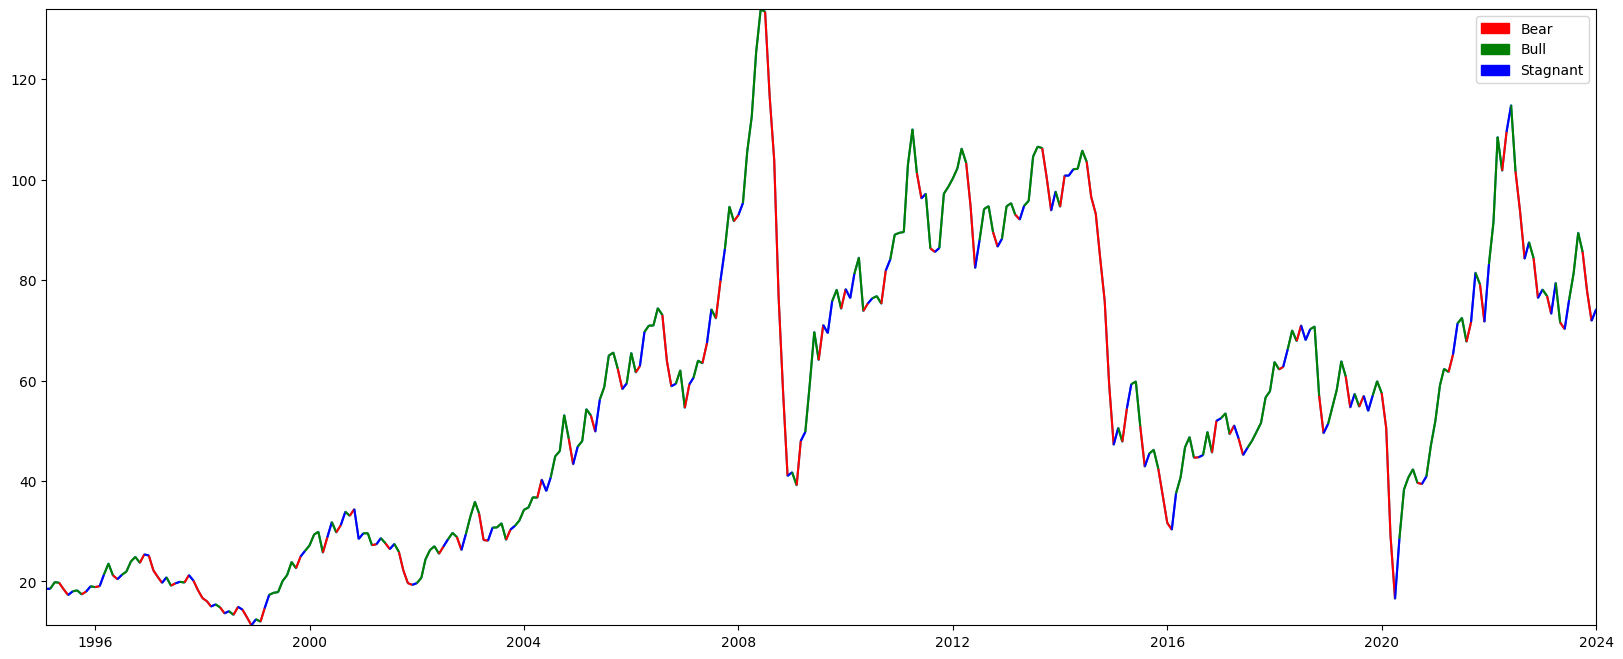

In [ ]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

fig, ax = plt.subplots(figsize=(20,8));
ax.plot(oil_prices['WTISPLC']);

price_plot ['WTISPLC'] = oil_prices['WTISPLC']

# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green

cmap   = ListedColormap(['r','b','g'],'indexed');
norm   = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);

lc = LineCollection(segments, cmap=cmap, norm=norm);
lc.set_array(price_plot['Regime']);
plt.gca().add_collection(lc);
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max());
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max());

r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');

plt.legend(handles=[r_patch, g_patch, b_patch]);

plt.show();

In [ ]:
import numpy as np
import hmms

datasets = data.columns.tolist()

for series_id in datasets:
    print("--------------", series_id)

    if series_id == 'forecast':
        break

    # Initialize a random discrete-time HMM with 3 hidden states and 2 emissions
    dhmm = hmms.DtHMM.random(3, 2)

    # Calculate differences and create emission sequences
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array_split(data_diff.gt(0).astype(int).values, 32)

    # Check dimensions of each sequence
    valid_sequences = [seq for seq in emit_seq if seq.ndim == 1]

    if len(valid_sequences) == 0:
        print(f"Skipping {series_id} due to invalid sequence dimensions.")
        continue

    # Train the HMM using the Baum-Welch algorithm
    try:
        dhmm.baum_welch(valid_sequences, 100)
    except ValueError as e:
        print(f"Error training HMM for {series_id}: {e}")
        continue

    # Replace '.' with '_' for valid filenames
    path = series_id.replace(".", "_")

    # Save the trained model parameters
    dhmm.save_params(path)

    # If additional training is required, uncomment the lines below
    # dhmm.baum_welch(valid_sequences, 100)
    # dhmm.save_params(path)


-------------- RGDPQ_NONOECD
iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100


In [ ]:
import pandas as pd
import hmms

# Create a DataFrame to store the test results
disc_test = pd.DataFrame(index=train_data[1:].index)

# Iterate over each series in the dataset
for series_id in datasets:
    # Create the file path for the HMM model
    path = series_id.replace(".", "_") + ".npz"

    try:
        # Load the HMM model from file
        if series_id == 'forecast':
            dhmm = hmms.DtHMM.from_file('WTISPLC.npz')
        else:
            dhmm = hmms.DtHMM.from_file(path)
    except FileNotFoundError:
        # If the file is not found, print a message and skip to the next series
        print(f"File not found for {series_id}. Skipping this series.")
        continue

    # Calculate differences and create emission sequence
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)

    # Run the Viterbi algorithm to find the most likely state sequence
    log_prob, s_seq = dhmm.viterbi(emit_seq)

    # Store the state sequence in the DataFrame
    disc_test[series_id] = s_seq

# Save the DataFrame to a CSV file
disc_test.to_csv("train_data.csv")


Plot all datasets and store

In [ ]:
states = pd.read_csv("train_data.csv", index_col=0);

for series_id in datasets:

        df = pd.DataFrame(index=train_data[1:].index);
        df[series_id] = train_data[series_id][1:];
        df['Diff'] = train_data[series_id].diff()[1:];
        df['Regime'] = states[series_id];

        # Get means of all assigned states
        means = df.groupby(['Regime'])['Diff'].mean();
        lst_1 = means.index.tolist();
        lst_2 = means.sort_values().index.tolist();

        map_regimes = dict(zip(lst_2, lst_1));
        df['Regime'] = df['Regime'].map(map_regimes);


        cmap   = ListedColormap(['r','b','g'],'indexed');
        norm   = BoundaryNorm(range(3 + 1), cmap.N);
        inxval = mdates.date2num(df[series_id].index.to_pydatetime());
        points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2);
        segments = np.concatenate([points[:-1], points[1:]], axis=1);

        lc = LineCollection(segments, cmap=cmap, norm=norm);
        lc.set_array(df['Regime']);
        plt.gca().add_collection(lc);
        plt.xlim(df[series_id].index.min(), df[series_id].index.max());
        plt.ylim(df[series_id].min(), df[series_id].max());

        r_patch = mpatches.Patch(color='red', label='Bear');
        g_patch = mpatches.Patch(color='green', label='Bull');
        b_patch = mpatches.Patch(color='blue', label='Stagnant');

        plt.legend(handles=[r_patch, g_patch, b_patch]);

        name = series_id.replace(".", "_") + ".png";

        plt.savefig(name);
        plt.close();

### Construct a Bayesian Network to Model Oil Markets
Given that we have discretised our training dataset, we can now use pgmpy to construct a belief network of all the variables.

We would be using the Hill Climbing approach to learn the belief network. We have given a brief description of the Hill Climbing algorithm in the thesis and would now be using its implementation pgmpy to learn the structure of the oil markets.

We shall begin with importing the relevant modules from pgmpy in Python.

Given we would be using the BIC Scoring Algorithm as the scoring function for Hill Climbing, we will import the relevant functions from the relevant module in pgmpy.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import BicScore, K2Score, BDeuScore

# Retrieve training set
train_data = pd.read_csv("train_data.csv", index_col=0);

In [ ]:
#  Initialise Hill Climbing Estimator
hc = HillClimbSearch(train_data)
#hc.scoring_method = K2Score(train_data);
expert =  BayesianNetwork();
expert.add_nodes_from(datasets);
expert.add_edges_from([
                        ('PAPR_NONOPEC', 'WTISPLC'),
                        ('PAPR_OPEC', 'WTISPLC'),
                        ('PATC_OECD', 'WTISPLC'),
                        ('PATC_NON_OECD', 'WTISPLC'),
                        ('RGDPQ_OECD', 'PATC_OECD'),
                        ('RGDPQ_NONOECD', 'PATC_NON_OECD'),
                      ]);

model_structure = hc.estimate(scoring_method=K2Score(data))



In [ ]:
model_a = BayesianNetwork(model_structure.edges()) # Create BayesianNetwork from DAG

model_a.fit(train_data,
          state_names=dict(map(lambda e: (e, [0, 1, 2]), datasets)),
          estimator=BayesianEstimator, prior_type="K2");

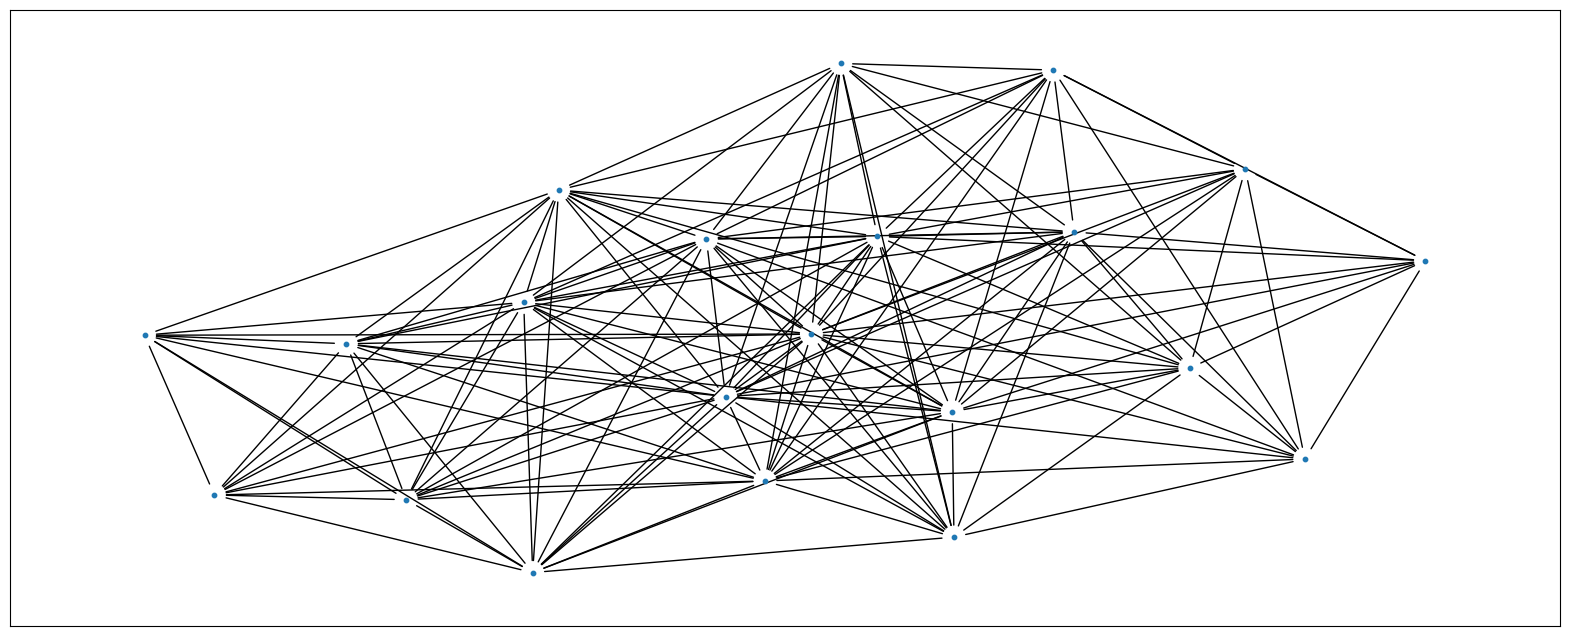

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import networkx as nx
import pylab as plt


G=nx.Graph();
G.add_edges_from(model_a.edges());
pos = nx.spring_layout(G);
nx.draw_networkx_nodes(G, pos, node_size = 10);
nx.draw_networkx_edges(G, pos, arrows=True);
plt.figure(5,figsize=(20,10));

#Validation

We can also represent our model in the form of a directed graph, using NetworkX.

We have now fitted our model using the Hill Climb search, and now can make inferences using forecasts as evidence.

Validation
We have successfully fitted our model to the data and need to test our model now.

We will now be using our validation dataset and would be making predictions on that and would be accordingly adjusting our model if we are not satisfied by the performance.

We first have to discretise the validation dataset. We would be using the HMMs trained on the training set. We CANNOT use the validation set to train anything, including HMMs!

In [ ]:
discrete_vald = pd.DataFrame(index = vald_data[1:].index);

for series_id in datasets:
    path =   series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff =  vald_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
    discrete_vald[series_id] = s_seq;

discrete_vald.to_csv("validation_data.csv"); # Saving to CSV

In [ ]:
states = pd.read_csv("validation_data.csv", index_col=0);

for series_id in datasets:

        df = pd.DataFrame(index=vald_data[1:].index);
        df[series_id] = vald_data[series_id][1:];
        df['Diff'] = vald_data[series_id].diff()[1:];
        df['Regime'] = states[series_id];

        # Get means of all assigned states

        means = df.groupby(['Regime'])['Diff'].mean();

        lst_1 = means.index.tolist();
        lst_2 = means.sort_values().index.tolist();

        map_regimes = dict(zip(lst_2, lst_1));
        df['Regime'] = df['Regime'].map(map_regimes);


        cmap   = ListedColormap(['r','b','g'],'indexed');
        norm   = BoundaryNorm(range(3 + 1), cmap.N);
        inxval = mdates.date2num(df[series_id].index.to_pydatetime());
        points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2);
        segments = np.concatenate([points[:-1], points[1:]], axis=1);

        lc = LineCollection(segments, cmap=cmap, norm=norm);
        lc.set_array(df['Regime']);
        plt.gca().add_collection(lc);
        plt.xlim(df[series_id].index.min(), df[series_id].index.max());
        plt.ylim(df[series_id].min(), df[series_id].max());

        r_patch = mpatches.Patch(color='red', label='Bear');
        g_patch = mpatches.Patch(color='green', label='Bull');
        b_patch = mpatches.Patch(color='blue', label='Stagnant');

        plt.legend(handles=[r_patch, g_patch, b_patch]);

        name = series_id.replace(".", "_") + "_VALIDATION.png";

        plt.savefig(name);
        plt.close();

In [ ]:
# Record real data observation, to be compared with the predicted one
vald_real = states['WTISPLC'].to_numpy()

# Drop the real data observation so that it does not bias prediction
vald_data_new = states.drop('forecast', axis=1);

# Inference on the constructed graphical model
vald_prediction = model_a.predict(vald_data_new);

# Retrieve it as an array so we can compare with real value
pred_value_vald = vald_prediction['forecast'].to_numpy();

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
print("\nPredicted Value: ");
print(pred_value_vald);
print("\nReal Value: ");
print(vald_real);

error = np.mean(vald_real !=  np.roll(pred_value_vald, 1));
#error = np.mean(vald_real != pred_value_vald);
print("\nError: ");
print(error * 100);


Predicted Value: 
[1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0 0 1 1 0]

Real Value: 
[0 0 0 2 1 0 0 0 2 2 1 0 2 1 1 0 0 0 2 1 1]

Error: 
38.095238095238095


#Testing
Similar to what we did with the validation data set, we first have to discretise the test dataset, and predict it on the BayesianModel.

In [ ]:
discrete_test = pd.DataFrame(index = test_data[1:].index);

for series_id in datasets:
    path = series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff =  test_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
    discrete_test[series_id] = s_seq;

discrete_test.to_csv("test_data.csv");

In [ ]:
discrete_test = pd.read_csv("test_data.csv", index_col=0);

# Record real data observation, to be compared with the predicted one
test_real = discrete_test['WTISPLC'].to_numpy()

# Drop the real data observation so that it does not bias prediction
test_data_new = discrete_test.drop('forecast', axis=1);

# Inference on the constructed graphical model
test_prediction = model_a.predict(test_data_new);

# Retrieve it as an array so we can compare with real value
pred_value_test = test_prediction['forecast'].to_numpy()

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
print("\nPredicted Value: ");

# This is the price, not the forecast
print(pred_value_test);
print("\nReal Value: ");
print(test_real);

# Shift to get forecast
error = np.mean(test_real != np.roll(pred_value_test, 1));
#error = np.mean(test_real != pred_value_test); # Shift to get forecast
print("\nError: ");
print(error * 100);


Predicted Value: 
[1 0 1 2 1 1 1 0 1 0 0 2 1 0 0 2 0 2 0 1 1]

Real Value: 
[2 2 1 0 2 1 1 1 1 0 0 0 2 1 1 0 0 0 0 2 1]

Error: 
47.61904761904761


Now, we can use the discretised price predictions to construct a simple trading algorithm, which takes '0' as a shorting signal, '2' for a long position, and '1' for no action. We assume we start with one barrel of oil and we would be trading it to acquire a larger unit.

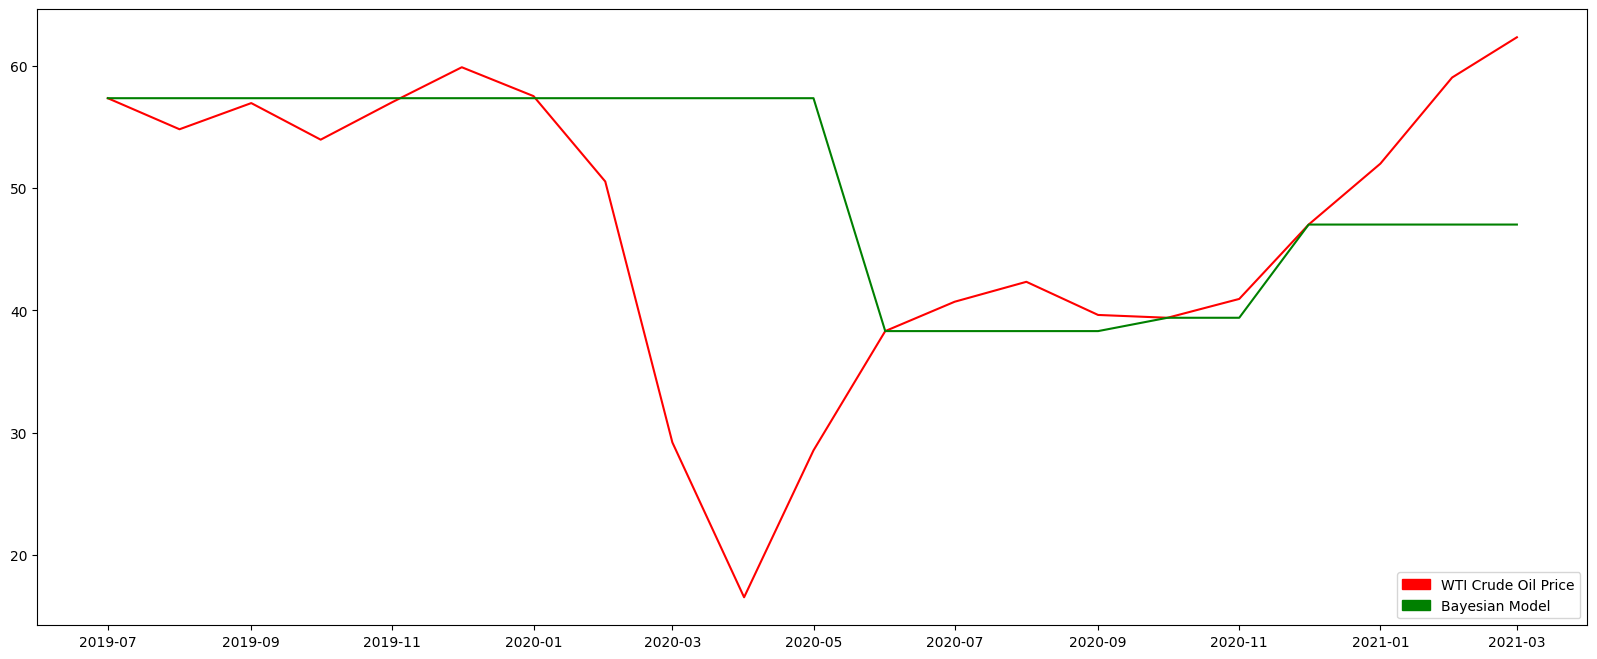

In [ ]:
test_price = pd.DataFrame(test_data['WTISPLC'], columns=['WTISPLC']);
test_signal = pd.DataFrame(test_prediction, columns=['forecast']);
test_signal.index = test_price.index[:21]
test_sheet = pd.concat([test_price, test_signal], axis=1, join='inner');

trades = [test_sheet['WTISPLC'].iloc[0]];

position = False; # True for Long, False for Short

for i in range(len(test_sheet)-1):
    if test_sheet['forecast'].iloc[i+1] == 0:
        trades.append(trades[-1]);
    elif test_sheet['forecast'].iloc[i+1] == 2:
        if position == False:
            position = True;
            trades.append(trades[-1]);
        else:
            trades.append(test_sheet['WTISPLC'].iloc[i+1]);
    else:
        trades.append(trades[-1]);

#eia_forecast = pd.read_csv("eia_forecast.csv", index_col=0);
#eia_forecast.index = test_signal.index;
test_performance = pd.DataFrame(trades, index = test_signal.index,
                                            columns=['performance']);
test_sheet = pd.concat([test_sheet, test_performance], axis=1, join='inner');


plt.plot(test_sheet['WTISPLC'], 'r');
plt.plot(test_sheet['performance'], 'g');
#plt.plot(eia_forecast['eia_forecast'], 'b');

r_patch = mpatches.Patch(color='red', label='WTI Crude Oil Price');
g_patch = mpatches.Patch(color='green', label='Bayesian Model');
b_patch = mpatches.Patch(color='blue', label='EIA Forecast');

plt.legend(handles=[r_patch, g_patch], loc = 'lower right');

In [ ]:
import pandas as pd

# Data from the user's input
data = {
    "Date": [
        "Jun 2024", "Jul 2024", "Aug 2024", "Sep 2024", "Oct 2024", "Nov 2024", "Dec 2024",
        "Jan 2025", "Feb 2025", "Mar 2025", "Apr 2025", "May 2025", "Jun 2025",
        "Jul 2025", "Aug 2025", "Sep 2025", "Oct 2025", "Nov 2025", "Dec 2025"
    ],
    "EIA_STEO_Forecast": [
        79.77, 82.50, 83.50, 84.50, 84.50, 85.50, 85.50,
        86.50, 86.50, 85.50, 84.50, 84.50, 84.50,
        83.50, 83.50, 83.50, 81.50, 81.50, 81.50
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set the 'Date' column as the index
df['Date'] = pd.to_datetime(df['Date'], format='%b %Y')
df.set_index('Date', inplace=True)

# Display the DataFrame
print(df)


            EIA_STEO_Forecast
Date                         
2024-06-01              79.77
2024-07-01              82.50
2024-08-01              83.50
2024-09-01              84.50
2024-10-01              84.50
2024-11-01              85.50
2024-12-01              85.50
2025-01-01              86.50
2025-02-01              86.50
2025-03-01              85.50
2025-04-01              84.50
2025-05-01              84.50
2025-06-01              84.50
2025-07-01              83.50
2025-08-01              83.50
2025-09-01              83.50
2025-10-01              81.50
2025-11-01              81.50
2025-12-01              81.50


#Conclusion

Regime detection is a key step in the process of forecasting oil prices. Using HMM enables us to capture the price dynamics of the oil markets - non-linear dynamcis and complex dependencies.

The hmms python library provides a core set of algorithms to enable this calculation - Baum-Welch and Viterbi functionality.

They key model assumtion here is that the oil prices have these three states - bull, bear and stagnant. The model forecasting is fully dependent on this assumption.

#References

[1] Ankan, Ankur and Abinash Panda. “pgmpy: Probabilistic Graphical Models using Python.” SciPy (2015).

[2]  “U.S. Energy Information Administration - EIA - Independent Statistics and Analysis.” Energy & Financial Markets: What Drives Crude Oil Prices? - Energy Information Administration, www.eia.gov/finance/markets/crudeoil/. Accessed 17 July 2024.

[3] CFA Institute, CFA Program Curriculum 2023 Level 2 Volume 1 Quantitative Methods Economics. Wiley, 2024

[4]  David R. Westhead, M. S. Vijayabaskar (eds.) - Hidden Markov Models  Methods and Protocols -Humana Press (2017)

[5] Foster, John Bellamy. "What is stagnation?." The Imperiled Economy, Book I, Macroeconomics from a left perspective, New York: URPE (1987).

[6] Hidden Markov Models, web.stanford.edu/~jurafsky/slp3/A.pdf. Accessed 20 July 2024.

[7] Vasques, Xavier. Machine Learning Theory and Applications: Hands-on Use Cases with Python on Classical and Quantum Machines. Wiley, 2024.

[8] Zhang, Yanxue, Dongmei Zhao, and Jinxing Liu. The application of Baum‐Welch algorithm in multistep attack. The Scientific World Journal 2014.1 (2014): 374260.